In [ ]:
pip install ucimlrepo

In [ ]:
!pip install ucimlrepo scikit-learn xgboost matplotlib seaborn

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler

In [ ]:
# fetch dataset
covertype = fetch_ucirepo(id=31)

# data (as pandas dataframes)
X = covertype.data.features
y = covertype.data.targets

# metadata
print(covertype.metadata)

# variable information
print(covertype.variables)

print("Shape of features:", X.shape)
print("Shape of target:", y.shape)
print("\nTarget value counts:\n", y.value_counts())

{'uci_id': 31, 'name': 'Covertype', 'repository_url': 'https://archive.ics.uci.edu/dataset/31/covertype', 'data_url': 'https://archive.ics.uci.edu/static/public/31/data.csv', 'abstract': 'Classification of pixels into 7 forest cover types based on attributes such as elevation, aspect, slope, hillshade, soil-type, and more.', 'area': 'Biology', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 581012, 'num_features': 54, 'feature_types': ['Categorical', 'Integer'], 'demographics': [], 'target_col': ['Cover_Type'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1998, 'last_updated': 'Sat Mar 16 2024', 'dataset_doi': '10.24432/C50K5N', 'creators': ['Jock Blackard'], 'intro_paper': None, 'additional_info': {'summary': 'Predicting forest cover type from cartographic variables only (no remotely sensed data).  The actual forest cover type for a given observation (30 x 30 meter cell) was determined from

In [ ]:
# Identify continuous variables
continuous_cols = [col for col in X.columns if X[col].nunique() > 2]
categorical_cols = [col for col in X.columns if X[col].nunique() <= 2]

# Scale continuous variables
scaler = StandardScaler()
X_scaled = X.copy()
X_scaled[continuous_cols] = scaler.fit_transform(X[continuous_cols])

In [ ]:
# 4. Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



--- Random Forest Results ---
Accuracy: 0.953804979217404
              precision    recall  f1-score   support

           1       0.96      0.94      0.95     42368
           2       0.95      0.97      0.96     56661
           3       0.94      0.96      0.95      7151
           4       0.91      0.86      0.88       549
           5       0.95      0.78      0.86      1899
           6       0.93      0.89      0.91      3473
           7       0.97      0.95      0.96      4102

    accuracy                           0.95    116203
   macro avg       0.95      0.91      0.92    116203
weighted avg       0.95      0.95      0.95    116203



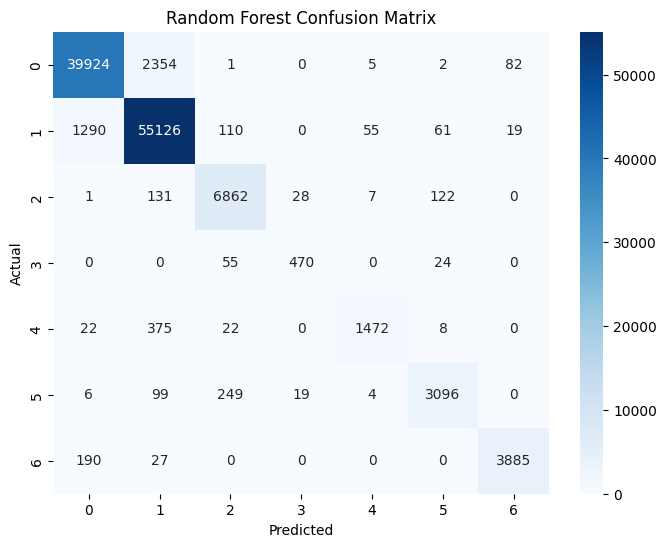

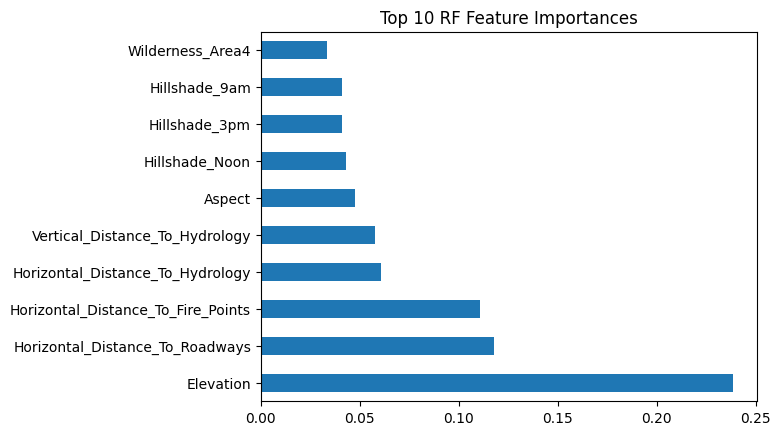

In [ ]:
# 5. Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)

print("\n--- Random Forest Results ---")
print("Accuracy:", accuracy_score(y_test, rf_preds))
print(classification_report(y_test, rf_preds))

# Confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, rf_preds), annot=True, fmt="d", cmap="Blues")
plt.title("Random Forest Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature importance (Random Forest)
rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
rf_importances.nlargest(10).plot(kind='barh', title='Top 10 RF Feature Importances')
plt.show()

/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [04:23:38] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost Results ---
Accuracy: 0.908074662444171
              precision    recall  f1-score   support

           0       0.91      0.88      0.89     42368
           1       0.90      0.93      0.92     56661
           2       0.93      0.95      0.94      7151
           3       0.90      0.87      0.88       549
           4       0.90      0.76      0.82      1899
           5       0.90      0.88      0.89      3473
           6       0.96      0.95      0.95      4102

    accuracy                           0.91    116203
   macro avg       0.91      0.89      0.90    116203
weighted avg       0.91      0.91      0.91    116203



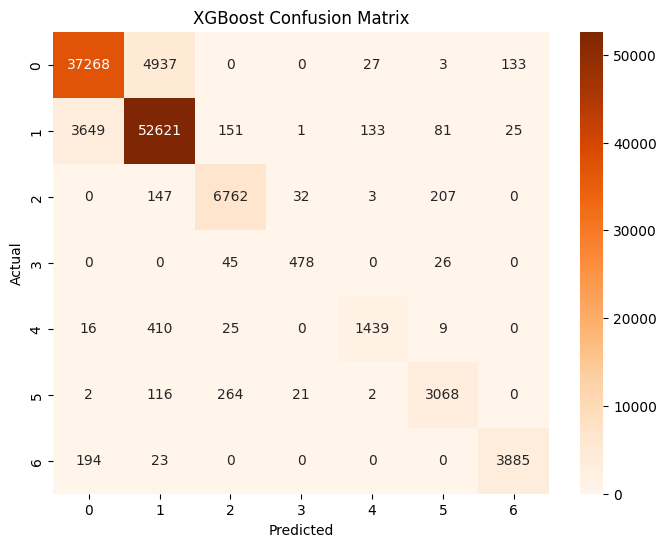

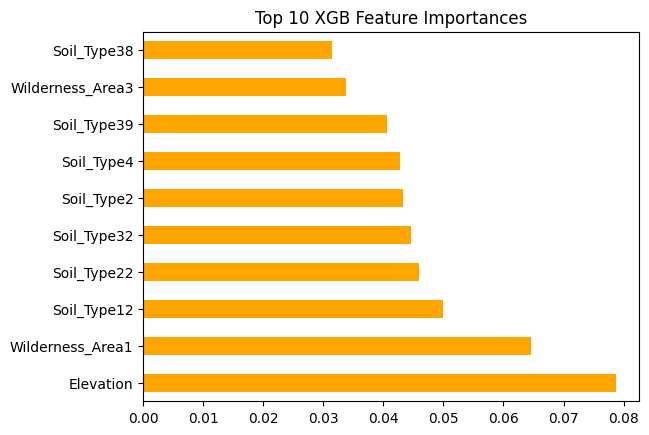

In [ ]:
# Convert y to Series and shift labels to start at 0
y = y.squeeze() - 1

# Train/test split again after label fix
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

# XGBoost model
xgb_model = XGBClassifier(
    objective='multi:softmax',
    num_class=len(y.unique()),
    eval_metric='mlogloss',
    use_label_encoder=False,
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

print("\n--- XGBoost Results ---")
print("Accuracy:", accuracy_score(y_test, xgb_preds))
print(classification_report(y_test, xgb_preds))

# Confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, xgb_preds), annot=True, fmt="d", cmap="Oranges")
plt.title("XGBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature importance
xgb_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)
xgb_importances.nlargest(10).plot(kind='barh', title='Top 10 XGB Feature Importances', color='orange')
plt.show()

In [ ]:
# 7. Bonus: Hyperparameter Tuning (Random Forest)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    scoring='accuracy',
    verbose=2
)

grid_search.fit(X_train, y_train)
print("\nBest RF Parameters:", grid_search.best_params_)
print("Best RF Accuracy:", grid_search.best_score_)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time= 1.4min
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time= 2.8min
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time= 2.9min
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time= 2.8min
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time= 1.4min
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time= 1.3min
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time= 1.3min
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time= 2.7min
[CV] END max_depth=None, min_samples_split=5, n_estimators=200; total time= 2.6min
[CV] END max_depth=None, m